In [2]:
# Suggested imports. Do not use import any modules that are not in the requirements.txt file on the VLE.

%matplotlib inline

import numpy as np
import pandas as pd
import torch
import collections
import random
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

c:\Users\maxma\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Movie titles assignment

Table of contents:

* [Data filtering and splitting (10%)](#Data-filtering-and-splitting-(10%))
* [Title classification (25%)](#Title-classification-(25%))
* [Title generation (25%)](#Title-generation-(25%))
* [Language models as classifiers (30%)](#Language-models-as-classifiers-(30%))
* [Conclusion (10%)](#Conclusion-(10%))

Information:

This assignment is 100% of your assessment.
You are to follow the instructions below and fill each cell as instructed.
Once ready, submit this notebook on VLE with all the outputs included (run all your code and don't clear any output cells).
Do not submit anything else apart from the notebook and do not use any extra data apart from what is requested.

## Introduction

A big shot Hollywood producer is looking for a way to automatically generate new movie titles for future movies and you have been employed to do this (in exchange for millions of dollars!).
A data set of movie details has already been collected from IMDb for you and your task is to create the model and the algorithms necessary to use it.

## Data filtering and splitting (10%)

Start by downloading the CSV file `filmtv_movies - ENG.csv` from [this kaggle data set](https://www.kaggle.com/datasets/stefanoleone992/filmtv-movies-dataset).

The CSV file needs to be filtered as the producer is only interested in certain types of movie titles.
Load the file and filter it so that only movies with the following criteria are kept:

* The country needs to be `United States` (and no other country should be mentioned).
* The genre should be `Action`, `Horror`, `Fantasy`, `Western`, and `Adventure`.
* The title should not have more than 20 characters.

In [3]:
data = pd.read_csv('Data/filmtv_movies - ENG.csv', index_col=None)

In [4]:
genres = ['Action', 'Horror', 'Fantasy', 'Western', 'Adventure']

data = data.loc[(data['country'] == 'United States') &
                (data['genre'].isin(genres)) & 
                (data['title'].str.len() <= 20)]

Split the filtered data into 80% train, 10% validation, and 10% test.
You will only need the title and genre columns.

In [5]:
data = data[['title', 'genre']]
train, validate, test = np.split(data.sample(frac=1), [int(.8*len(data)), int(.9*len(data))])

From your processed data set, display:

* the amount of movies in each genre and split
* 5 examples of movie titles from each genre and split

In [6]:
print(f"Training Set Size: {len(train)}")
print(f"Validation Set Size: {len(validate)}")
print(f"Test Set Size: {len(test)}")

for genre in data['genre'].unique():
    print(f"Num. of movies with genre {genre}: {len(data[data['genre'] == genre])} ")

Training Set Size: 2736
Validation Set Size: 342
Test Set Size: 342
Num. of movies with genre Horror: 926 
Num. of movies with genre Action: 914 
Num. of movies with genre Western: 538 
Num. of movies with genre Adventure: 483 
Num. of movies with genre Fantasy: 559 


## Title classification (25%)

Your first task is to prove that a neural network can identify the genre of a movie based on its title.

You will note that many titles are just a single word or two words long so you need to work at the character level instead of the word level, that is, a token would be a single character, including punctuation marks and spaces.
You must also lowercase the titles.
Preprocess the data sets, create a neural network, and train it to classify the movie titles into their genre.
Plot a graph of the **accuracy** of the model on the train and validation sets after each epoch.

In [7]:
train['title'] = train['title'].str.lower()
titles_temp = train['title'].values
titles = [list(title) for title in titles_temp]

In [8]:
min_freq = 3

In [84]:
# Training Set
train_x = []
train_y = []
for row in range(0, len(train)):
    title = list(train.iloc[row]['title'].lower())
    genre = [train.iloc[row]['genre']]

    train_x.append(title)
    train_y.append(genre)

# Testing Set
test_x = []
test_y = []
for row in range(0, len(test)):
    title = list(test.iloc[row]['title'].lower())
    genre = [test.iloc[row]['genre']]

    test_x.append(title)
    test_y.append(genre)

# Lengths
train_lens = torch.tensor(
    [len(title) for title in train_x],
    dtype=torch.int64, device=device
)

test_lens = torch.tensor(
    [len(title) for title in test_x],
    dtype=torch.int64, device=device
)

max_len = max(max(train_lens), max(test_lens))

# Genres
genre = sorted(set(genre for text in train_y for genre in text))
genre = sorted(genre)

# Genre Indexing
genre2index = {genre: i for (i, genre) in enumerate(genre)}

# vocab
frequencies = collections.Counter(letter for text in train_x for word in text for letter in word)
vocab = sorted(frequencies.keys(), key=frequencies.get, reverse=True)
while frequencies[vocab[-1]] < min_freq:
    vocab.pop()
vocab = ['<PAD>', '<UNK>'] + sorted(vocab)
letter2index = {letter: i for (i, letter) in enumerate(vocab)}

# Padding and UNK indexing
for i in range(len(train_x)):
    for j in range(len(train_x[i])):
        if train_x[i][j] not in letter2index:
            train_x[i][j] = '<UNK>'
    
    for x in range(0, (max_len - len(train_x[i]))):
        train_x[i].extend(['<PAD>'])
    
    temp_ans = train_y[i]
    train_y[i] = [0] * len(genre)
    train_y[i][genre2index[temp_ans[0]]] = 1

for i in range(len(test_x)):
    for j in range(len(test_x[i])):
        if test_x[i][j] not in letter2index:
            test_x[i][j] = '<UNK>'

    for x in range(0, (max_len - len(test_x[i]))):
        test_x[i].extend(['<PAD>'])
    
    temp_ans = test_y[i]
    test_y[i] = [0] * len(genre)
    test_y[i][genre2index[temp_ans[0]]] = 1

# indexing
indexed_train_x = torch.tensor([[letter2index[letter] for letter in text] for text in train_x], 
                                dtype=torch.int64, 
                                device=device)
indexed_train_y = torch.tensor([y for y in train_y],
                                dtype=torch.float32, 
                                device=device)

indexed_test_x = torch.tensor([[letter2index[letter] for letter in text] for text in test_x], 
                                dtype=torch.int64, 
                                device=device)
indexed_test_y = torch.tensor([y for y in test_y],
                                dtype=torch.float32, 
                                device=device)


In [85]:
print(f'First 10 vocab: {vocab[:10]}')
print(f'Last 10 vocab: {vocab[-10:]}')
print(f'Vocab Size: {len(vocab)}\n')

print(f'First train_x:\n {train_x[1]}\n')
print(f'First train_y: {train_y[0]}\n')

print(f'Genres: {genre}\n')

print(f'First indexed_train_x:\n {indexed_train_x[0]}')
print(f'First indexed_train_y:\n {indexed_train_y[0]}\n')

print(f'First indexed_test_x:\n {indexed_test_x[0]}')
print(f'First indexed_test_y:\n {indexed_test_y[0]}')

First 10 vocab: ['<PAD>', '<UNK>', ' ', '!', '&', "'", ',', '-', '.', '/']
Last 10 vocab: ['q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab Size: 47

First train_x:
 ['b', 'o', 'r', 'd', 'e', 'l', 'l', 'o', ' ', 'o', 'f', ' ', 'b', 'l', 'o', 'o', 'd', '<PAD>', '<PAD>', '<PAD>']

First train_y: [0, 0, 0, 1, 0]

Genres: ['Action', 'Adventure', 'Fantasy', 'Horror', 'Western']

First indexed_train_x:
 tensor([40, 28, 25,  2, 40, 29, 34, 27, 32, 25, 38,  0,  0,  0,  0,  0,  0,  0,
         0,  0])
First indexed_train_y:
 tensor([0., 0., 0., 1., 0.])

First indexed_test_x:
 tensor([23, 38, 35, 39, 39, 43, 35, 38, 32, 24, 39,  0,  0,  0,  0,  0,  0,  0,
         0,  0])
First indexed_test_y:
 tensor([0., 0., 1., 0., 0.])


In [86]:
class Model(torch.nn.Module):

    def __init__(self, chars_size, embedding_size, hidden_size, genre_size, max_len):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(chars_size, embedding_size)
        self.output_layer = torch.nn.Linear(max_len*hidden_size, genre_size) # Output size number of genres
    
    def forward(self, x):
        hidden = self.embedding_layer(x)
        flattened = torch.flatten(hidden, 1, 2)
        return self.output_layer(flattened)

In [97]:
class GenreClassifier():
    
    def __init__(self, chars, iters, title_lens, genre_size, embedding, hidden, max_len):
        self.model = Model(chars_size=len(chars), embedding_size=embedding, hidden_size=hidden, genre_size=genre_size, max_len=max_len)
        self.model.to(device)
        self.optimiser = torch.optim.Adam(self.model.parameters())

        self.iters = iters
        self.title_lens = title_lens
        self.train_errors = []
    
    def run(self, indexed_train_x, indexed_train_y):
        print('step', 'error')
        self.train_errors = []

        for step in range(1, self.iters + 1):  
            self.optimiser.zero_grad()
            output = self.model(indexed_train_x)
            error = torch.nn.functional.binary_cross_entropy_with_logits(output, indexed_train_y)
            self.train_errors.append(error.detach().tolist())
            error.backward()
            self.optimiser.step()

            if step%100 == 0:
                print(step, self.train_errors[-1])  

        
        
    def backTesting(self, test_x, test_y):
        with torch.no_grad():
            predictions = torch.sigmoid(self.model(test_x))
            accuracy = (torch.round(predictions) == test_y).numpy().mean()
            print('Test accuracy: {:.3%}'.format(accuracy))

    def errors(self):
        (fig, ax) = plt.subplots(1, 1)
        ax.set_xlabel('step')
        ax.set_ylabel('$E$')
        ax.plot(range(1, len(self.train_errors) + 1), self.train_errors, color='blue', linestyle='-', linewidth=3)
        ax.grid()

step error
100 0.43550747632980347
200 0.4097324311733246
300 0.39303699135780334
400 0.38064685463905334
500 0.3707454204559326
600 0.3624686002731323
700 0.3554020822048187
800 0.3493238091468811
900 0.3440958261489868
1000 0.3396016061306


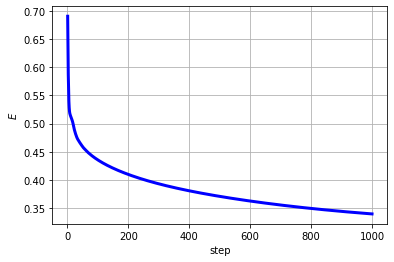

In [98]:
classifier = GenreClassifier(chars=vocab, iters=1000, title_lens=train_lens, genre_size=len(genre), embedding=32, hidden=32, max_len=max_len)
classifier.run(indexed_train_x, indexed_train_y)
classifier.errors()

In [99]:
classifier.backTesting(indexed_test_x, indexed_test_y)

Test accuracy: 73.743%


Measure the F1 score performance of the model when applied on the test set.
Also plot a confusion matrix showing how often each genre is mistaken as another genre.

## Title generation (25%)

Now that you've proven that titles and genre are related, make a model that can generate a title given a genre.

Again, you need to generate tokens at the character level instead of the word level and the titles must be lowercased.
Preprocess the data sets, create a neural network, and train it to generate the movie titles given their genre.
Plot a graph of the **perplexity** of the model on the train and validation sets after each epoch.

Generate 3 titles for every genre.
Make sure that the titles are not all the same.

## Language models as classifiers (30%)

It occurs to you that the movie title generator can also be used as a classifier by doing the following:

* Let title $t$ be the title that you want to classify.
* For every genre $g$,
    * Use the generator as a language model to get the probability of $t$ (the whole title) using genre $g$.
* Pick the genre that makes the language model give the largest probability.

The producer is thrilled to not need two separate models and now you have to implement this.
**Use the preprocessed test set from the previous task** in order to find the genre that makes the language model give the largest probability.
There is no need to plot anything here.

Just like in the classification task, measure the F1 score and plot the confusion matrix of this new classifier.

Write a paragraph or psuedo code to describe what your code above does.

In [ ]:
'''

'''

## Conclusion (10%)

The producer's funders are asking for a report about this new technology they invested in.
In 300 words, write your interpretation of the results together with what you think could make the model perform better.

In [ ]:
'''

'''